In [ ]:
"""

這份檔案要用來執行特徵工程部分，主要利用pandas來進行處理


input：四份資料夾內文件，training、public、public_processed、private_1_processed

output：特徵處理完的training dataset(processed_data.parquet)、validation dataset(val_data.parquet)


"""

In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import Counter
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
import datetime
from sklearn.metrics import precision_recall_curve

from scipy.stats import entropy

In [39]:
# 載入資料 
old_train = pd.read_csv('data1/training.csv')
new_train = pd.read_csv('data1/public.csv')
second_train = pd.read_csv('data2/private_1.csv')

second_val = pd.read_csv('data2/private_2_processed.csv')

example = pd.read_csv('data2/private_2_template_v2.csv')

# df = pd.concat([old_train, new_train, new_val],sort=False)
# df_copy = df.copy()

In [40]:
old_train

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,stocn,scity,stscd,ovrlt,flbmk,hcefg,csmcu,csmam,flg_3dsmk,label
0,1c09727c939eb69ead2a4ce4072b8aa18992a64f01fcb4...,46,101812,84d2dc85d4da6a7fa284a11a4290d7e9a969163dcb4d82...,3dd5bf1e29e5e0baa789ce692fe5dbd34ff05173acf351...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,375.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,1529,0,0
1,2043f245a93bc6328dac964d6dbc89f13a0346062c194d...,17,85509,9a8cf5d0afd729cb7876f6b3172152c7c9c6fabd40515c...,8cb13f9b38c7bbc02d210e580dcbbcbb6c95bf18bc3320...,5,8.0,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,282.0,...,0.0,15759.0,NaN,0,0,8.0,70.0,101,0,0
2,e4853710290a8409279f3279f8032ae670824bd19aa173...,44,212641,dcc1389a5765d6f53152cf85970fbe78a83fd3d1c299b0...,1ec32868e5e1d5ff8df56737c2a91326cbfe3364382de6...,5,4.0,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,288.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,116,0,0
3,74d811b1dbc28b22b73ba2c79bb6033791d913b6d27a25...,42,102702,577f2329d1eccd59ba0abaf6113bb78dcd575badcbc57f...,4359dca1ac6a835eceb2bc0dd6b0b710f030c3499126e9...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,36684976be1f529e6e2a32c9edab4cf8e364b2b916ae2c...,375.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,1683,0,0
4,68ca182343969d429d79a34e532bc1ca7a3cc032c2ad81...,31,185737,fff6b4126c40620b1fbb11d4de02cd67b9e95071caa40b...,a3837f2905383f235a72679482c5f02e40f2a8ca29750d...,5,5.0,50d5b02ce3fc88723438c2a29cfdb04be4a1a11280ddb6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,14,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688521,fe5788aae7affa13a3946608670d7cdb9b4cde44f8f2cf...,14,84737,a894ea5eaf2c114231806da124f9d422b2c74653f071ec...,4616fbb5e28fbf86012461fc98652f51af00d2226aa634...,5,4.0,3c31ae50e4d36fe64a518a2c8109d14dd8d6b3a08edc92...,5f9c23caf7da7e1cf1e53ff9eab71dde3cfd72819e5210...,282.0,...,0.0,15759.0,NaN,0,0,0.0,70.0,49,0,0
8688522,8a2b5b7ba4443c311f06be147e42e7493735ae203c48ba...,23,105923,e3ee9fcf2bbabdfb2a4e6a7dfca046f1597888a8ebc3d2...,29e5be6d2bc0f3e539f13675c3faada5f07afb6f6df40a...,5,4.0,f56737b0e28217d7958e7ef135df60a5a02451c61596ef...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,276.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,4018,0,0
8688523,15a9ef847ce3702a176abfaceedf9a22a328e27a0c99a9...,23,141030,85a538fe0cb00a82ebdb948f1a8b45bfea5005dfcf7dcb...,2990660b8172986c57c793f16bb565ae29cd7572b50f05...,5,4.0,5f5906af767850a3d99fee5fc7ec9025467c4f9d9c8070...,2fea345d14a69774026f3de93f5e3313219363d54e07b1...,272.0,...,0.0,11380.0,NaN,0,0,6.0,70.0,314,0,0
8688524,2ed4454b4fcce6b9f98c3c22a1df941f03beb14bce94ea...,10,120209,1dd744fc7ca8249f3eb54514530bd9c242d338421ef819...,fca665553fe576b40984abe18261056736b923c3310f1d...,5,5.0,c795cb82dae8d6605d4856d4f2fa58cf1b0e158457fab8...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,272.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,225,0,0


In [41]:
second_train

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,stocn,scity,stscd,ovrlt,flbmk,hcefg,csmcu,csmam,flg_3dsmk,label
0,060c98e010d9de67efec769dd515e06f90a609754de453...,61,122833,2eae3caf5a8353528f79480d9a4f5ea9255300aa6b2e4a...,30bd604c6de3826afa74bc7f800dd6b530e286ce6732ae...,5,3.0,f3a67a7ac399353a91fba7ad4e96bdbc9aa5e750c488a2...,bcf6370b700fb26d1fab05dad5de442b2bf37689cb55fd...,305.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,2478,0,0
1,d4f2d0fe210acdf19c9a95735d6d843df98e30b33188cc...,61,203434,f1bb20aa70f95520b434419632ab9ccb19441fb7757a51...,f29a95f8031ec2b6ecdc20963bd95954b1c3e81537b606...,5,5.0,e8d98e44151198526e079fdcc7f44c1e16be6f1fc2fb96...,2fea345d14a69774026f3de93f5e3313219363d54e07b1...,276.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,80,0,0
2,6d0c82bc52e3cdb5e97c63ae9462c0d891be44103d7aa8...,64,91830,a72095b5bd4fc4dfa8e58723fef0dfe22d6cc2980848d7...,6a4e636eeb3950362a8ccaa8a7b3b88741b8062f603d85...,5,4.0,29e17a7a8f9b3b929eefbf5ece7e5490c05d5d5ab00a9e...,afd552b955eb0861c738e0b1835bf7b76a8105d39ceba6...,288.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,872,0,0
3,a32d3deb79456f7a3eb14c15f912f05fd07e3679ef46c8...,61,220855,64f1c2db22fe4ca83e87fef1101a43db4922403ada4a49...,24196eeb068a64732cf17ff1b451133e41756c18ad41f7...,2,1.0,44b7ec50322a27d56d01b58a9ec1eb152aee84c7c53283...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,289.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,146,0,0
4,52ad1cc1fb605e9206c5e45e4ded11da04a0ae1fbceca4...,60,91525,e6ea2b1ce9d95134af3ed9a081c6b25368d568d020c1ca...,3dbf193cf361b948d01a4d30f9d5f959ea8453f09aa80a...,4,5.0,cf7fa71ad44fa7bb56c50dc98e33febfecac5514851057...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,375.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,7700,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800759,fdae1741c3e7ff7921f472b27aa8f85022c183a55f5960...,61,95503,95fef5c95b0682ce427108f4b5837e3f08817a46256a86...,319196d19fdf8a713165ef0d9cd9b18a8fe6f9bf273454...,5,8.0,75a558c50ce3a8bae9173f3926da060c9fad1f6e2ce199...,c97d528fd1af914249e82d697161f2b788b8af69885bcd...,276.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,11506,0,0
800760,cd377ac4fcaa1635488014502ee31bd2379d24d8bf0e09...,62,203016,f6365e7ec82893c4f845ea3392598d1e5626cb03943265...,17c814aeb46fcc082310b408aad6a35ca1be46894cbb17...,5,5.0,939d9bffeb7c5264ce4ef1aa8502894cd7971324893784...,bcf6370b700fb26d1fab05dad5de442b2bf37689cb55fd...,415.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,25,0,0
800761,3dee3158309e849195e4e9e036295589cbb524163f994f...,60,214908,6907f849d281f2c06922c57eacbcf41c12ec3296b4c0fc...,ae35eca999d1646a3eb1414b0961ee7a240af2a81233e5...,5,3.0,6511b3e27dd9a9bf8299c4fe1d37fd96b69ee8ddff1c01...,bcf6370b700fb26d1fab05dad5de442b2bf37689cb55fd...,213.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,1026,0,0
800762,3eaaf68d918b6b2e29d4460f8b6815aa0247a48dbf7afc...,63,223254,ca2e8556020477f4934c487e099887cd43418d3cef1be7...,949435be9c3b8e12da3c5e0677f7ae167958a6547547c4...,4,1.0,79ea7b4902585fcf1c58268ebfc610f97b1ec3346d1f54...,9cf4bcc128e82df5572434156fb02c2d471607b861272a...,349.0,...,0.0,13453.0,NaN,0,0,6.0,70.0,2379,0,0


In [42]:
second_val

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,flam1,stocn,scity,stscd,ovrlt,flbmk,hcefg,csmcu,csmam,flg_3dsmk
0,2dc3cfff76e54b508aec3a1ab7d3f3b9770d670c9cb988...,67,154643,0b00b7596618a1dda1f086253fa084514ac078df8c6508...,3f0492f98e1e4cbda2b00795706f6a241b4eda4d45791a...,5,4.0,a12ad248d519be41ec9cd95e1cc2d838bb09311752d644...,9cf4bcc128e82df5572434156fb02c2d471607b861272a...,272.0,...,589,0.0,16107.0,NaN,0,0,6.0,70.0,589,0
1,5e4e0386a88cdf7847631e80fb129bbbf942a8ab68390b...,65,163354,8767ee745f657378b7433878bbfbcf8de0d383b9096b44...,4f3b3ff55b0b7ba9bdc76369e37ec88d203081d74075f0...,5,4.0,3219da9e76531bfb2180f7bd052ae3abfb68d91167218f...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,320.0,...,10,0.0,15759.0,NaN,0,0,6.0,70.0,10,0
2,ba2ec4f84fa996e4dbcb42984451b217fe2e9cd0b7d3da...,65,82503,90a9d4c7f2a4e2bab655a76b338097c7b6210a52adf7a9...,fb35b9c306043bef50cdb8fcfb7e32fbc38c0e6532ab8b...,5,1.0,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,9b2d5b4678781e53038e91ea5324530a03f27dc1d0e5f6...,493.0,...,399,0.0,15759.0,NaN,0,0,NaN,NaN,0,0
3,a6f137a7444829310471ff9dd051addc349920ae07c5bb...,67,73639,e16ad06a616cde211d5bcb8c859bbb2c980a5b29feaecd...,229c692bb51a19a2094d24e8f36497ddc6685b534ed9b1...,5,5.0,0e657b0caf3a6703741b42ec2e6e0687564ac8f455acfd...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,282.0,...,80,0.0,15759.0,NaN,0,0,6.0,70.0,80,0
4,b4b3f47913e3142ca7cc54ab5d98fafc00174ad1c63206...,68,144256,1779dae34826e532bd9ce51814de354e286d8dc54fd936...,0bd5efae3516ef0e7d9317862299b763171d0b61f54352...,5,4.0,9a0745def1d0360253b70abc8f5a63e4a5e9d0b839ebca...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,276.0,...,210,0.0,15759.0,NaN,0,0,6.0,70.0,210,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805716,f192c75180efd46e8746c9926d48f89b4f9bd730974d67...,65,153455,b64dbeef5ec0b990d55769801f5b67f7a7ca6f7175a808...,f919d2ee7ec0f2bc088fb61595772bf86a3afb400432e7...,5,4.0,fb59a6c4236b61de59b7b456c9e4d3510f5b3215290288...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,282.0,...,188,0.0,15759.0,NaN,0,0,6.0,70.0,188,0
805717,79a032788e6f1c684a8c1ac514f8bd3c9fc99498698604...,65,225434,98ff72c6c41f764b8bdc4326609c1d3bb77d8f837a09f3...,ba5816da2a9e896079d0204ed010b8145fd6e50ba4eeaa...,5,8.0,6b7635b3c834659abdac7dcff723f0043e6a0e205e9cb2...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,276.0,...,1038,0.0,15808.0,NaN,0,0,1.0,70.0,1038,0
805718,03bd77b8d2e0fa4a2d5d6fa417afb3f94ba65e4d3075ff...,67,100118,bba97c1f0cec74e3cc05d8d05e7ef319b59d1724249f97...,5ae1053166a91be634d99a09fc9f076d9085aac283f061...,5,8.0,489e5caa6e2b65e6cbf57159c18b10b5cfb0d8e28bb3e3...,bcf6370b700fb26d1fab05dad5de442b2bf37689cb55fd...,378.0,...,3,0.0,15759.0,NaN,0,0,6.0,70.0,3,0
805719,ddea7082b8a1830efa2f80b36e02378475ad89b7b2fa74...,65,132802,a7baecc6840c7077e48681374370a4da1689edc012e9ac...,440d4d5ed70c75c1c7874ba7ea417162cd351e7137b9ed...,5,8.0,a5ec18857b0de164680a9574ee24f6705a3d7e342931f8...,70972a182dac8d19c55cdcd00355e9c7663917b4f813c8...,282.0,...,4638,54.0,5009.0,NaN,0,0,6.0,70.0,4638,0


In [43]:
example

,txkey,pred
0,2dc3cfff76e54b508aec3a1ab7d3f3b9770d670c9cb988...,0
1,5e4e0386a88cdf7847631e80fb129bbbf942a8ab68390b...,0
2,ba2ec4f84fa996e4dbcb42984451b217fe2e9cd0b7d3da...,0
3,a6f137a7444829310471ff9dd051addc349920ae07c5bb...,0
4,b4b3f47913e3142ca7cc54ab5d98fafc00174ad1c63206...,0
...,...,...
805716,f192c75180efd46e8746c9926d48f89b4f9bd730974d67...,0
805717,79a032788e6f1c684a8c1ac514f8bd3c9fc99498698604...,0
805718,03bd77b8d2e0fa4a2d5d6fa417afb3f94ba65e4d3075ff...,0
805719,ddea7082b8a1830efa2f80b36e02378475ad89b7b2fa74...,0


In [44]:
df = pd.concat([old_train, new_train, second_train, second_val],sort=False)

In [45]:
df_copy = df.copy()
df_copy

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,stocn,scity,stscd,ovrlt,flbmk,hcefg,csmcu,csmam,flg_3dsmk,label
0,1c09727c939eb69ead2a4ce4072b8aa18992a64f01fcb4...,46,101812,84d2dc85d4da6a7fa284a11a4290d7e9a969163dcb4d82...,3dd5bf1e29e5e0baa789ce692fe5dbd34ff05173acf351...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,375.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,1529,0,0.0
1,2043f245a93bc6328dac964d6dbc89f13a0346062c194d...,17,85509,9a8cf5d0afd729cb7876f6b3172152c7c9c6fabd40515c...,8cb13f9b38c7bbc02d210e580dcbbcbb6c95bf18bc3320...,5,8.0,4356c6642ef6e837543b577c7ee3ffa92b4b8fcfb57254...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,282.0,...,0.0,15759.0,NaN,0,0,8.0,70.0,101,0,0.0
2,e4853710290a8409279f3279f8032ae670824bd19aa173...,44,212641,dcc1389a5765d6f53152cf85970fbe78a83fd3d1c299b0...,1ec32868e5e1d5ff8df56737c2a91326cbfe3364382de6...,5,4.0,5b7eff061f8896aac4339ea35c25f8bb956a43bc486460...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,288.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,116,0,0.0
3,74d811b1dbc28b22b73ba2c79bb6033791d913b6d27a25...,42,102702,577f2329d1eccd59ba0abaf6113bb78dcd575badcbc57f...,4359dca1ac6a835eceb2bc0dd6b0b710f030c3499126e9...,5,1.0,cad752c5d05d2bdcc30d64fa4e68404c2d1f7be5d14d52...,36684976be1f529e6e2a32c9edab4cf8e364b2b916ae2c...,375.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,1683,0,0.0
4,68ca182343969d429d79a34e532bc1ca7a3cc032c2ad81...,31,185737,fff6b4126c40620b1fbb11d4de02cd67b9e95071caa40b...,a3837f2905383f235a72679482c5f02e40f2a8ca29750d...,5,5.0,50d5b02ce3fc88723438c2a29cfdb04be4a1a11280ddb6...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,14,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805716,f192c75180efd46e8746c9926d48f89b4f9bd730974d67...,65,153455,b64dbeef5ec0b990d55769801f5b67f7a7ca6f7175a808...,f919d2ee7ec0f2bc088fb61595772bf86a3afb400432e7...,5,4.0,fb59a6c4236b61de59b7b456c9e4d3510f5b3215290288...,8f6b3ff512a001e0d1988c6cd888ef8c74112fb71117e5...,282.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,188,0,NaN
805717,79a032788e6f1c684a8c1ac514f8bd3c9fc99498698604...,65,225434,98ff72c6c41f764b8bdc4326609c1d3bb77d8f837a09f3...,ba5816da2a9e896079d0204ed010b8145fd6e50ba4eeaa...,5,8.0,6b7635b3c834659abdac7dcff723f0043e6a0e205e9cb2...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,276.0,...,0.0,15808.0,NaN,0,0,1.0,70.0,1038,0,NaN
805718,03bd77b8d2e0fa4a2d5d6fa417afb3f94ba65e4d3075ff...,67,100118,bba97c1f0cec74e3cc05d8d05e7ef319b59d1724249f97...,5ae1053166a91be634d99a09fc9f076d9085aac283f061...,5,8.0,489e5caa6e2b65e6cbf57159c18b10b5cfb0d8e28bb3e3...,bcf6370b700fb26d1fab05dad5de442b2bf37689cb55fd...,378.0,...,0.0,15759.0,NaN,0,0,6.0,70.0,3,0,NaN
805719,ddea7082b8a1830efa2f80b36e02378475ad89b7b2fa74...,65,132802,a7baecc6840c7077e48681374370a4da1689edc012e9ac...,440d4d5ed70c75c1c7874ba7ea417162cd351e7137b9ed...,5,8.0,a5ec18857b0de164680a9574ee24f6705a3d7e342931f8...,70972a182dac8d19c55cdcd00355e9c7663917b4f813c8...,282.0,...,54.0,5009.0,NaN,0,0,6.0,70.0,4638,0,NaN


In [46]:
# Step 1 計算交易活動，計算特定卡在前30天消費所佔的次數比率與之後的比率，計算之間的變化率

# 計算每張卡在其持有者所有交易中的活動次數
card_activity_count = df_copy.groupby(['chid', 'cano'])['txkey'].count()
card_activity_count = card_activity_count.rename('card_transaction_count').reset_index()
df_copy = df_copy.merge(card_activity_count, on=['chid', 'cano'], how='left')

# 計算每個持卡人的總交易次數
customer_total_transactions = df_copy.groupby('chid')['txkey'].count()
customer_total_transactions = customer_total_transactions.rename('customer_total_transactions').reset_index()

# 將每個持卡人的總交易次數合併到主資料集
df_copy = df_copy.merge(customer_total_transactions, on='chid', how='left')

# 篩選前30天的交易數據
df_copy_before_30 = df_copy[df_copy['locdt'] <= 30]

# 計算前30天的交易比例
card_activity_before_30 = df_copy_before_30.groupby(['chid', 'cano'])['txkey'].count().reset_index()
total_transactions_before_30 = df_copy_before_30.groupby('chid')['txkey'].count().reset_index()
card_ratio_before_30 = card_activity_before_30.merge(total_transactions_before_30, on='chid')
card_ratio_before_30['card_transaction_ratio_before_30'] = card_ratio_before_30['txkey_x'] / card_ratio_before_30['txkey_y']

# 篩選後30天的交易數據
df_copy_after_30 = df_copy[df_copy['locdt'] > 30]

# 計算後30天的交易比例
card_activity_after_30 = df_copy_after_30.groupby(['chid', 'cano'])['txkey'].count().reset_index()
total_transactions_after_30 = df_copy_after_30.groupby('chid')['txkey'].count().reset_index()
card_ratio_after_30 = card_activity_after_30.merge(total_transactions_after_30, on='chid')
card_ratio_after_30['card_transaction_ratio_after_30'] = card_ratio_after_30['txkey_x'] / card_ratio_after_30['txkey_y']

# 計算前後30天的比例變化率
card_ratio_change = card_ratio_before_30.merge(card_ratio_after_30, on=['chid', 'cano'])
card_ratio_change['ratio_change'] = (card_ratio_change['card_transaction_ratio_after_30'] - card_ratio_change['card_transaction_ratio_before_30']) / card_ratio_change['card_transaction_ratio_before_30']

# 已經計算好的 card_ratio_before_30, card_ratio_after_30, 和 card_ratio_change

# 將重要的欄位合併到 df_copy
df_copy = df_copy.merge(card_ratio_before_30[['chid', 'cano', 'card_transaction_ratio_before_30']], on=['chid', 'cano'], how='left')
df_copy = df_copy.merge(card_ratio_after_30[['chid', 'cano', 'card_transaction_ratio_after_30']], on=['chid', 'cano'], how='left')
df_copy = df_copy.merge(card_ratio_change[['chid', 'cano', 'ratio_change']], on=['chid', 'cano'], how='left')


In [47]:
# Step 2 計算每個卡號每天的交易頻率並進行正規化處理


# Step 1: 計算每個卡號的總交易次數
transaction_count_per_cano = df_copy.groupby('cano')['txkey'].count().reset_index()
transaction_count_per_cano.columns = ['cano', 'total_transactions']

# Step 2: 計算每筆交易與上一次交易的間隔天數
df_copy = df_copy.sort_values(by=['cano', 'locdt'])
df_copy['previous_transaction_date'] = df_copy.groupby('cano')['locdt'].shift(1)
df_copy['days_since_last_transaction'] = df_copy['locdt'] - df_copy['previous_transaction_date']

# Step 3: 計算每個卡號的平均使用頻率
df_copy = df_copy.merge(transaction_count_per_cano, on='cano', how='left')
df_copy['first_use_date'] = df_copy.groupby('cano')['locdt'].transform('min')
df_copy['last_use_date'] = df_copy.groupby('cano')['locdt'].transform('max')
df_copy['days_active'] = df_copy['last_use_date'] - df_copy['first_use_date'] + 1
df_copy['average_use_frequency'] = df_copy['days_active'] / df_copy['total_transactions']

# 確保數據的正確性
df_copy['days_since_last_transaction'].fillna(-1, inplace=True) 




In [48]:
# Step 3 計算每個卡號的交易金額並進行正規化處理

# 定義MAD函數
def mad(series):
    return (series - series.median()).abs().median()

# Step 1: 計算每個卡號的交易金額的MAD
mad_per_cano = df_copy.groupby('cano')['conam'].apply(mad).reset_index()
mad_per_cano.columns = ['cano', 'mad_conam']

# Step 2: 將MAD值添加回原始數據框
df_copy = df_copy.merge(mad_per_cano, on='cano', how='left')

# Step 3: 計算差異
df_copy['conam_diff_from_mad'] = df_copy['conam'] - df_copy['mad_conam']


In [51]:
# Step 4 計算上次刷卡時間(秒數)

def impute_time_zero(x):
    x = str(int(x)).zfill(6)
    return datetime.datetime.strptime(x, "%H%M%S").time()

# Apply the function to convert 'loctm' to time objects
df_copy['loctm'] = df_copy['loctm'].apply(impute_time_zero)

# Sort the DataFrame based on card number and transaction datetime
sorted_df = df_copy.sort_values(by=['cano', 'locdt', 'loctm'])

# Group by 'cano' and shift the 'locdt' and 'loctm' to get the previous transaction's date and time
sorted_df['prev_locdt'] = sorted_df.groupby('cano')['locdt'].shift(1)
sorted_df['prev_loctm'] = sorted_df.groupby('cano')['loctm'].shift(1)

# Calculate the seconds since midnight for 'loctm' and 'prev_loctm'
sorted_df['loctm_seconds'] = sorted_df['loctm'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
sorted_df['prev_loctm_seconds'] = sorted_df['prev_loctm'].apply(
    lambda x: x.hour * 3600 + x.minute * 60 + x.second if pd.notnull(x) else 0)

# Calculate the difference in days and convert to seconds, then add the difference in seconds
sorted_df['difference_seconds'] = (sorted_df['locdt'] - sorted_df['prev_locdt']) * 86400 + \
                                  (sorted_df['loctm_seconds'] - sorted_df['prev_loctm_seconds'])

# For the first transaction, we don't have a previous transaction time, so we set it to -1
sorted_df['difference_seconds'] = sorted_df['difference_seconds'].fillna(-1)

# Merge the result back into the original DataFrame
df_copy = df_copy.merge(sorted_df[['txkey', 'difference_seconds']], on='txkey', how='left')

# Display the head of the DataFrame to confirm the changes
df_copy.head()

,txkey,locdt,loctm,chid,cano,contp,etymd,mchno,acqic,mcc,...,previous_transaction_date,days_since_last_transaction,total_transactions,first_use_date,last_use_date,days_active,average_use_frequency,mad_conam,conam_diff_from_mad,difference_seconds
0,338c2f393db78b044726a41e033413b96a8575ad1ea067...,9,09:41:52,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,09dd1fa2117349dc7fcbe7d88a8bbdab3eac610019010b...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,NaN,-1.0,2,9,9,1,0.5,6715.5,-1063.5,219.0
1,f099be3150b369dc097312df37a759d6ceb332181c2a63...,9,09:38:13,ae3ba1768efb2005cb0991eed4176e95d296ab00d3eb86...,000004e90549c10a46912120949a36bbe9c92fb02daa27...,5,3.0,c8131b6b345e94a8ff34642eae76ad4c71ce2027475ebc...,2a608b081c09492bd2bc96d7def5371c4bc9cabf324a98...,486.0,...,9.0,0.0,2,9,9,1,0.5,6715.5,12367.5,-1.0
2,ca0ceb8b5efafd9af240de906a8cb0a85cc246b723f60a...,5,17:57:11,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,12c5b8c7cac508b0cf7214cee8c8ea9ebe1e23c5b0dd67...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,288.0,...,NaN,-1.0,15,5,61,57,3.8,356.0,-203.0,-1.0
3,153da2c77542c25cc788526ec3c7efaa4b7d07bb14e691...,25,20:54:59,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,57671442d26d3dd982bf9cf95274e3da8dc575d3e4ec31...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,406.0,...,5.0,20.0,15,5,61,57,3.8,356.0,-302.0,1738668.0
4,2f18af76ab1bef5b7f0cbd336be4d8ada74f8b5cf646ea...,26,21:25:44,a9a2aa5dc322adb0f14897cbeb215cdc40fb9fc1f9bf13...,00002522901695edfbc8be6728ad6b5cd63f30a9a9b9c9...,5,5.0,07b64d578cadcf5495bcb1c0873c23c18067468f6a221c...,379166ff4a62dac343b4b734188aa618716cc496e48b65...,272.0,...,25.0,1.0,15,5,61,57,3.8,356.0,1127.0,88245.0


In [52]:
# Step 5 計算每個卡號刷卡的每筆之間的時間間隔的平均和標準差

def calculate_transaction_intervals(group):
    """
    計算信用卡交易時間間隔的平均值和標準差。

    :param group: Grouped DataFrame by 'cano'.
    :return: Tuple with average and standard deviation of transaction intervals in seconds.
    """
    # 計算日期差異（轉換為秒）和時間差異
    date_diffs = group['locdt'].diff().fillna(0) * 86400
    time_diffs = group['loctm_seconds'].diff().fillna(0)

    # 總時間差異
    total_diffs = date_diffs + time_diffs

    # 排除第一筆交易（因為它沒有前一筆交易可以比較）
    total_diffs = total_diffs[1:]

    # 計算平均值和標準差
    avg_interval = total_diffs.mean() if not total_diffs.empty else -1
    std_interval = total_diffs.std() if not total_diffs.empty else -1

    return avg_interval, std_interval

# 應用函數並創建新的 DataFrame
intervals_df = sorted_df.groupby('cano').apply(calculate_transaction_intervals)
intervals_df = pd.DataFrame(intervals_df.tolist(), index=intervals_df.index).reset_index()
intervals_df.columns = ['cano', 'avg_interval', 'std_interval']

# 合併到原始 DataFrame
df_copy = df_copy.merge(intervals_df, on='cano', how='left')

In [53]:
# Step 6 每張卡號在不同商品類別（mcc）下的交易情況

# 計算每個卡號在每個MCC下的交易金額差異

median_per_mcc = df_copy.groupby('mcc')['conam'].median().reset_index()
median_per_mcc.columns = ['mcc', 'median_conam_per_mcc']

df_copy = df_copy.merge(median_per_mcc, on='mcc', how='left')

df_copy['conam_diff_mcc'] = df_copy['conam'] - df_copy['median_conam_per_mcc']

# 計算每個卡號在每個MCC下的交易比例

mcc_count_per_cano = df_copy.groupby(['cano', 'mcc']).cumcount() + 1
df_copy['mcc_count_per_cano'] = mcc_count_per_cano

total_transactions_per_cano = df_copy.groupby('cano')['txkey'].transform('count')
df_copy['mcc_freq_ratio'] = df_copy['mcc_count_per_cano'] / total_transactions_per_cano



In [54]:
# Step 7: 分析每張卡號在不同 mchno下的交易情況

# 計算每個卡號在每個 mchno下的交易金額差異

median_per_mchno = df_copy.groupby('mchno')['conam'].median().reset_index()
median_per_mchno.columns = ['mchno', 'median_conam_per_mchno']

df_copy = df_copy.merge(median_per_mchno, on='mchno', how='left')

df_copy['conam_diff_mchno'] = df_copy['conam'] - df_copy['median_conam_per_mchno']

# 計算每個卡號在每個 mchno下的交易比例

mchno_count_per_cano = df_copy.groupby(['cano', 'mchno']).cumcount() + 1
df_copy['mchno_count_per_cano'] = mcc_count_per_cano

total_transactions_per_cano = df_copy.groupby('cano')['txkey'].transform('count')
df_copy['mchno_freq_ratio'] = df_copy['mchno_count_per_cano'] / total_transactions_per_cano



In [55]:
# Step 8 觀察交易地點變化

# Step 1: 計算每個卡號在每個城市和國家的總交易次數
city_transaction_counts = df_copy.groupby(['cano', 'scity']).size().reset_index(name='city_count')
country_transaction_counts = df_copy.groupby(['cano', 'stocn']).size().reset_index(name='country_count')

# Step 2: 最大最小標準化
def min_max_scale(series):
    return (series - series.min()) / (series.max() - series.min()) * 100

city_transaction_counts['city_score'] = min_max_scale(city_transaction_counts['city_count'])
country_transaction_counts['country_score'] = min_max_scale(country_transaction_counts['country_count'])

# Step 3: 將轉換後的分數合併到原始數據框
df_copy = df_copy.merge(city_transaction_counts[['cano', 'scity', 'city_score']], on=['cano', 'scity'], how='left')
df_copy = df_copy.merge(country_transaction_counts[['cano', 'stocn', 'country_score']], on=['cano', 'stocn'], how='left')





In [56]:
# Step 9 把loctom拆成鐘點 

def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def time_to_hour(t):
    return t.hour

def time_to_string(t):
    return t.strftime("%H%M%S")

df_copy['hour'] = df_copy['loctm'].apply(time_to_hour)
df_copy['loctm_seconds'] = df_copy['loctm'].apply(time_to_seconds)
df_copy['loctm'] = df_copy['loctm'].apply(time_to_string)


In [57]:
train_data = pd.concat([old_train, new_train, second_train],sort=False)
new_train_data = df_copy.merge(train_data[['txkey']], on='txkey', how='inner')
new_val_data = df_copy.merge(example[['txkey']], on='txkey', how='inner')

In [61]:
cat_features = ['contp', 'etymd', 'mcc', 'ecfg', 'stocn', 'scity', 'insfg', 'mchno', 'acqic',
                'stscd', 'hcefg', 'csmcu', 'flg_3dsmk', 'hour']

columns_to_drop = ['label', 'txkey', 'chid', 'cano', 'bnsfg', 'flbmk', 'ovrlt', 'iterm', 'first_use_date',
                   'last_use_date', 'days_active']

# 從數據框中刪除指定的列
X = new_train_data.drop(columns=columns_to_drop)
y = new_train_data['label']


In [62]:
for feature in cat_features:
    X[feature] = X[feature].astype(str)
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.35, 
    random_state=40, 
    stratify=y
)

train_pool = Pool(X_train, y_train,cat_features=cat_features)
test_pool = Pool(X_test, y_test,cat_features=cat_features)

In [63]:
for feature in cat_features:
    X[feature] = X[feature].astype(str)
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.35, 
    random_state=40, 
    stratify=y
)

train_pool = Pool(X_train, y_train,cat_features=cat_features)
test_pool = Pool(X_test, y_test,cat_features=cat_features)

In [70]:
"""
註記：若電腦為MAC系列，則須無法使用 task_type='GPU'，可將其註解並且開啟subsample，接受另外兩個參數再進行訓練，超參數皆無須調整

"""
catboost_model = CatBoostClassifier(
    iterations=5000,  
    learning_rate=0.0765,
    depth=7,
    loss_function='Logloss',
    eval_metric='F1',  
    early_stopping_rounds=500,
    random_seed=42,
    verbose=100,
    l2_leaf_reg=3,
    leaf_estimation_iterations=10,
    colsample_bylevel=0.8,
    subsample=0.85,
    max_ctr_complexity=10,
#     task_type='GPU',
    scale_pos_weight = 9.35, # 9.45
    random_strength=3,
    grow_policy='Lossguide'
)

catboost_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)

0:	learn: 0.8481921	test: 0.8500659	best: 0.8500659 (0)	total: 1.61s	remaining: 2h 14m 20s
100:	learn: 0.9164226	test: 0.9157306	best: 0.9158556 (99)	total: 2m 23s	remaining: 1h 55m 36s
200:	learn: 0.9302458	test: 0.9255256	best: 0.9255256 (200)	total: 4m 51s	remaining: 1h 56m 1s
300:	learn: 0.9418728	test: 0.9327726	best: 0.9327726 (300)	total: 7m 5s	remaining: 1h 50m 38s
400:	learn: 0.9498999	test: 0.9384845	best: 0.9384845 (400)	total: 9m 7s	remaining: 1h 44m 43s
500:	learn: 0.9569375	test: 0.9438146	best: 0.9438146 (500)	total: 11m 5s	remaining: 1h 39m 35s
600:	learn: 0.9622362	test: 0.9464727	best: 0.9464767 (599)	total: 13m 1s	remaining: 1h 35m 18s
700:	learn: 0.9661670	test: 0.9483984	best: 0.9485467 (695)	total: 14m 50s	remaining: 1h 30m 58s
800:	learn: 0.9696428	test: 0.9501022	best: 0.9502713 (789)	total: 16m 39s	remaining: 1h 27m 19s
900:	learn: 0.9727747	test: 0.9517177	best: 0.9517177 (900)	total: 18m 28s	remaining: 1h 24m 3s
1000:	learn: 0.9755051	test: 0.9531337	best: 0.

In [73]:
# 預測概率
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

# 計算精確度和召回率以及閾值
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 計算 F1 分數
f1_scores = 2 * recall * precision / (recall + precision)
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]

# 使用最佳閾值進行預測
y_pred_custom = (y_pred_proba > best_threshold).astype(int)

# 計算調整後的精確度和召回率
adjusted_precision = precision_score(y_test, y_pred_custom)
adjusted_recall = recall_score(y_test, y_pred_custom)
adjusted_f1 = f1_score(y_test, y_pred_custom)

print(f"Best Threshold: {best_threshold}")
print(f"Adjusted Precision: {adjusted_precision}")
print(f"Adjusted Recall: {adjusted_recall}")

Best Threshold: 0.7577747057300599
Adjusted Precision: 0.9419632194888942
Adjusted Recall: 0.9009365719942131


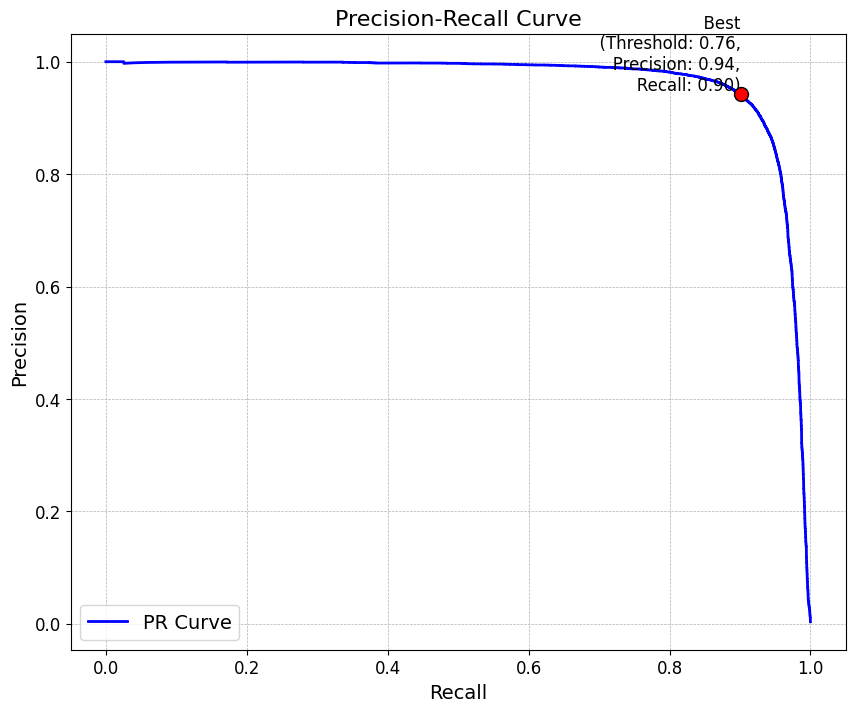

In [74]:
import matplotlib.pyplot as plt

# 假設 y_test 和 y_pred_proba 已經定義好
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# 計算 F1 分數
f1_scores = 2 * recall * precision / (recall + precision)

# 找到最大 F1 分數對應的閾值
max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]
best_precision = precision[max_f1_index]
best_recall = recall[max_f1_index]

# 繪製 PR 曲線
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label='PR Curve', color='blue', linewidth=2)
plt.scatter(best_recall, best_precision, color='red', s=100, edgecolor='black', zorder=5)
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 標記最佳閾值和對應的精確度、召回率
plt.text(best_recall, best_precision, f'  Best\n  (Threshold: {best_threshold:.2f},\n   Precision: {best_precision:.2f},\n   Recall: {best_recall:.2f})', 
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)

plt.legend(fontsize=14)
plt.show()



In [76]:
new_val_data = new_val_data.set_index('txkey')
columns_to_drop = ['chid', 'cano', 'bnsfg', 'flbmk', 'ovrlt', 'iterm', 'first_use_date',
                   'last_use_date', 'days_active']

cat_features = ['contp', 'etymd', 'mcc', 'ecfg', 'stocn', 'scity', 'insfg', 'mchno', 'acqic',
                'stscd', 'hcefg', 'csmcu', 'flg_3dsmk', 'hour']

X = new_val_data.drop(columns=columns_to_drop)

for feature in cat_features:
    X[feature] = X[feature].astype(str)
    
test_pool = Pool(X, cat_features=cat_features)


In [77]:
y_pred_proba = catboost_model.predict_proba(test_pool)[:, 1]
y_pred_custom = (y_pred_proba > best_threshold).astype(int)
new_val_data['pred'] = y_pred_custom
new_val_data = new_val_data.reset_index()
output_df = new_val_data[['txkey', 'pred']].set_index('txkey')
example = example.drop_duplicates(subset='txkey')

df2_sorted = example[['txkey']].merge(output_df, on='txkey', how='left')
df2_sorted = df2_sorted.set_index('txkey')
df2_sorted

,pred
txkey,
2dc3cfff76e54b508aec3a1ab7d3f3b9770d670c9cb9888f45ab96039212d609,0
5e4e0386a88cdf7847631e80fb129bbbf942a8ab68390bed581bf25738547e2f,0
ba2ec4f84fa996e4dbcb42984451b217fe2e9cd0b7d3da363c76df34b59ee6e0,0
a6f137a7444829310471ff9dd051addc349920ae07c5bbbd86ee4a58c05c8d8f,0
b4b3f47913e3142ca7cc54ab5d98fafc00174ad1c632069b3babc30f7ad9daad,0
...,...
f192c75180efd46e8746c9926d48f89b4f9bd730974d675d68f6bedc82ecdc06,0
79a032788e6f1c684a8c1ac514f8bd3c9fc9949869860492e9e5bea9c623db83,0
03bd77b8d2e0fa4a2d5d6fa417afb3f94ba65e4d3075ff494c8690ce18af3378,0


In [79]:
df2_sorted['pred'].value_counts()

pred
0    801733
1      3988
Name: count, dtype: int64

In [82]:
df2_sorted.to_csv('data2/TEAM_4614.csv')